# SARIMAX (seasonal autoregressive integrated moving average with exogenous regressors) Model

## Import data, handle missing values, create a clean dataframe

In [190]:
import pandas as pd
import numpy as np
# import seaborn as sns
from math import floor, sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

ic = pd.read_excel("D:\DS\Mine\Corona\I22-01.xlsx", index_col=0, parse_dates=[0]) # Iran Corona
ic['total_vaccinations_f'] = ic['total_vaccinations'].interpolate(method='linear').fillna(0)
ic['stringency_index_f'] = ic['stringency_index'].fillna(method="ffill")
icf = ic.loc[ : , ['total_cases', 'new_cases', 'new_cases_smoothed',
                   'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_vaccinations_f', 'stringency_index_f']]
icf = icf.asfreq(None)
pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option('display.max_rows', 2000)
icf

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_vaccinations_f,stringency_index_f
date,,,,,,,,
2020-02-19,2,2,NaN,2,2,NaN,0.00,0.00
2020-02-20,5,3,NaN,2,0,NaN,0.00,2.78
2020-02-21,18,13,NaN,4,2,NaN,0.00,2.78
2020-02-22,28,10,NaN,5,1,NaN,0.00,11.11
2020-02-23,43,15,NaN,8,3,NaN,0.00,11.11
...,...,...,...,...,...,...,...,...
2021-12-28,6188857,2128,"1,867.86",131474,40,43.86,"116,210,697.00",61.57
2021-12-29,6190762,1905,"1,839.57",131527,53,45.14,"116,210,697.00",61.57
2021-12-30,6192698,1936,"1,840.14",131572,45,44.29,"116,210,697.00",61.57


## Defining constants, spliting train and test

In [191]:
length = icf.shape[0]                #number of records
train_len = floor(length * 0.95)     #of records are going to be used for training
print('Out of', length, 'samples,', train_len, 'samples were devoted to training section and the rest (i.e.',
      length - train_len, 'samples) to test section.')
prl = 28   #4 weeks                                    #prediction lendth: number of days to predict

icn = icf.loc[:,'new_deaths']
xd = icn.values
xr = xd[:train_len]
xs = xd[train_len:train_len+prl]
xsp = []

Out of 683 samples, 648 samples were devoted to training section and the rest (i.e. 35 samples) to test section.


## Models

### Model 1: Auto ARIMA (Seasonal)

In [192]:
# The following line will make it possible to zoom and pan on graphs:
%matplotlib notebook

<IPython.core.display.Javascript object>


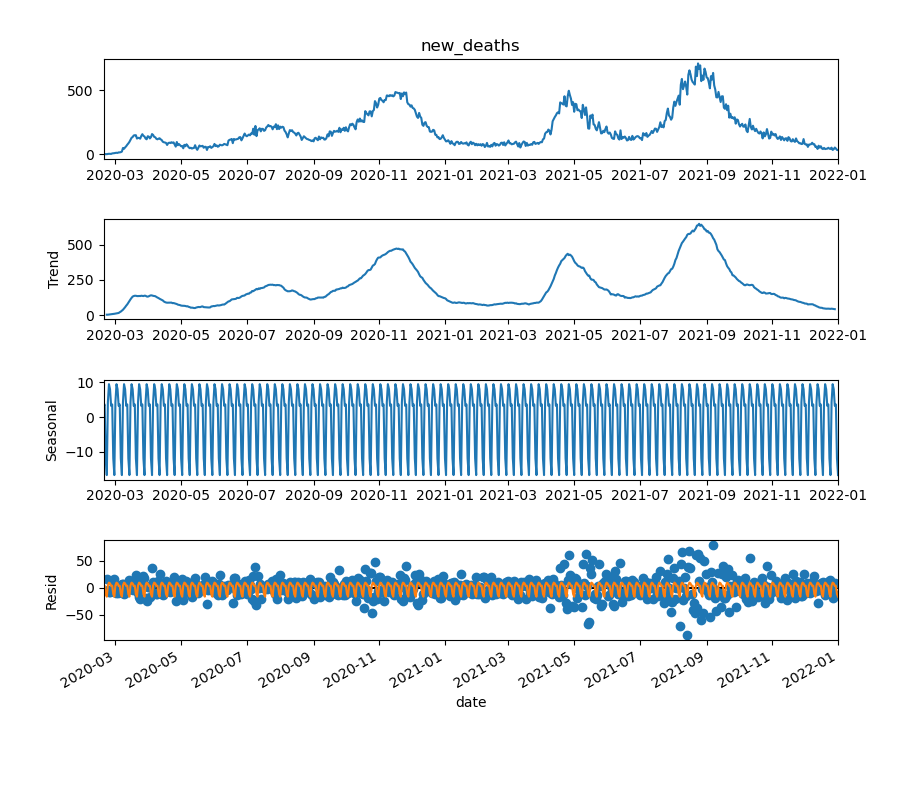

In [193]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(icf['new_deaths'])
res.plot();
res.seasonal.plot(figsize=(9, 8));

In [194]:
res.seasonal.head(15)

date
2020-02-19     3.21
2020-02-20     3.61
2020-02-21   -11.83
2020-02-22   -16.65
2020-02-23     4.27
2020-02-24     9.42
2020-02-25     7.96
2020-02-26     3.21
2020-02-27     3.61
2020-02-28   -11.83
2020-02-29   -16.65
2020-03-01     4.27
2020-03-02     9.42
2020-03-03     7.96
2020-03-04     3.21
Freq: D, Name: seasonal, dtype: float64

The seasonality period extracted by seasonal_decompose is 7 days.

In [195]:
seasonality_period = 7
# weeks_per_year = 365 // seasonality_period  #Floor division
# print('There are approximately', weeks_per_year, 'weeks per year.')

In [196]:
# pip install pmdarima # if you don't have pmdarima

In [197]:
from pmdarima import auto_arima
aa = auto_arima(xr, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=seasonality_period,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=5972.292, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=6400.920, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=6104.092, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=5972.572, Time=0.18 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=6198.274, Time=0.06 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=0.75 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=6066.705, Time=0.12 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=0.94 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=5976.312, Time=0.16 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=5974.214, Time=0.39 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=5965.897, Time=0.54 sec
 ARIMA(1,1,2)(0,1,0)[7]             : AIC=6165.326, Time=0.16 sec
 ARIMA(1,1,2)(1,1,1)[7]             : AIC=inf, Time=0.88 sec
 ARIMA(1,1,2)(0,1,2)[7]             : AIC=inf, Time=1

In [198]:
aa.fit(xr)

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(0, 1, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [199]:
aa.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 1, 1, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [200]:
enforce_stationary=False
enforce_invertibility=False

sm = SARIMAX(xr, order=aa.get_params()['order'], seasonal_order=aa.get_params()['seasonal_order'])
sm_fit = sm.fit(maxiter=500)
auto_arima_pr = sm_fit.predict(start=train_len, end=train_len+prl-1)
auto_arima_pr_df = pd.DataFrame(auto_arima_pr, index=icn.iloc[train_len:train_len+prl].index, columns=['Auto SARIMA'])
sm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  648
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -2977.948
Date:                             Sun, 16 Jan 2022   AIC                           5965.897
Time:                                     10:37:26   BIC                           5988.204
Sample:                                          0   HQIC                          5974.555
                                             - 648                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9631      0.026    -36.361      0.000      -1.015      -0.911
ma.L1          0.5923      0.040     14.962      0.000       0.515       0.670
ma.L2         -0.3107      0.033     -9.355      0.000      -0.376      -0.246
ma.S.L7       -0.8759      0.014    -63.467      0.000      -0.903      -0.849
sigma2       633.7055     25.322     25.026      0.000     584.076     683.335
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               104.01
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               5.28   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model 2: ARIMA (using the best parameters found in the previous study of ARIMA)

In [201]:
from statsmodels.tsa.arima.model import ARIMA
sm = ARIMA(xr, order=(6, 1, 2))
sm_fit = sm.fit()
arima_pr = sm_fit.predict(start=train_len, end=train_len+prl-1)
arima_pr_df = pd.DataFrame(arima_pr, index=icn.iloc[train_len:train_len+prl].index, columns=['Simple ARIMA'])
sm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  648
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -2992.851
Date:                Sun, 16 Jan 2022   AIC                           6003.701
Time:                        10:37:27   BIC                           6043.952
Sample:                             0   HQIC                          6019.317
                                - 648                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8707      0.054     16.271      0.000       0.766       0.976
ar.L2         -0.2385      0.043     -5.582      0.000      -0.322      -0.155
ar.L3         -0.0495      0.034     -1.443      0.149      -0.117       0.018
ar.L4          0.1426      0.038      3.733      0.000       0.068       0.218
ar.L5         -0.1863      0.034     -5.436      0.000      -0.253      -0.119
ar.L6          0.3475      0.027     12.802      0.000       0.294       0.401
ma.L1         -1.3107      0.058    -22.467      0.000      -1.425      -1.196
ma.L2          0.5028      0.055      9.212      0.000       0.396       0.610
sigma2       608.3994     24.489     24.844      0.000     560.402     656.397
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               130.41
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               5.03   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model 3: SARIMAX (using vaccination and stringency as exogenous data)

#### Estimation of exogenous data:

In [202]:
# Vaccination:

from scipy.optimize import curve_fit
vac_pr_days = 30    #number of days to be used for curve fitting prior to the test date 

def func(x, a, b, c, d, e):
#     return a * x ** 4 + b * x ** 3 + c * x ** 2 + d * x + e
#     return a * x ** 3 + b * x ** 2 + c * x + d
    return a * x ** 2 + b * x + c
#     return a * x + b

xdata = list(range(vac_pr_days))
ydata = icf.iloc[train_len - vac_pr_days:train_len, 6].values

popt = curve_fit(func, xdata, ydata)[0]
y_hat = [func(x, popt[0], popt[1], popt[2], popt[3], popt[4]) for x in range(vac_pr_days, vac_pr_days + prl)]

ydata_test = icf.iloc[train_len:train_len + prl, 6].values
print('MAE:  Mean Absolute Error =           ', "{:2.0f}".format(mean_absolute_error(ydata_test, y_hat)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.2%}".format(mean_absolute_percentage_error(ydata_test, y_hat)))
print('RMSE: Root Mean Squared Error =       ', "{:2.0f}".format(sqrt(mean_squared_error(ydata_test, y_hat))))

MAE:  Mean Absolute Error =            6749874
MAPE: Mean Absolute Percentage Error = 6.00%
RMSE: Root Mean Squared Error =        8423057


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Considering the error metrics, the model looks a reasonable estimation of vaccination. The warning is due to having 2 extra parameters for curve fitting function (func). It's for more flexibility in changing the model to linear, quadratic, cubic or power 4.

Assigning values to test section for vaccination and stringency:
    vaccination: predicted values
    stringency: we assume the same last value continues 

#### Assignment:

In [203]:
icf['total_vaccination_pr'] = np.zeros(length)
for x in range(train_len,train_len+prl):
    icf.iloc[x, 8] = y_hat[x - train_len]
icf['stringency_index_pr'] = np.zeros(length)
icf.iloc[train_len:train_len+prl, 9] = icf.iloc[train_len, 7]
icf.iloc[train_len:train_len+prl, 6:10]
# Comparing the actual values and predictions:

,total_vaccinations_f,stringency_index_f,total_vaccination_pr,stringency_index_pr
date,,,,
2021-11-28,"104,781,077.00",58.80,"104,360,527.62",58.80
2021-11-29,"105,174,033.29",58.80,"104,536,551.44",58.80
2021-11-30,"105,566,989.57",58.80,"104,683,327.50",58.80
2021-12-01,"105,959,945.86",61.57,"104,800,855.79",58.80
2021-12-02,"106,352,902.14",61.57,"104,889,136.31",58.80
2021-12-03,"106,745,858.43",61.57,"104,948,169.06",58.80
2021-12-04,"107,138,814.71",61.57,"104,977,954.05",58.80
2021-12-05,"107,531,771.00",65.28,"104,978,491.28",58.80
2021-12-06,"107,856,909.71",65.28,"104,949,780.73",58.80


In [204]:
# Column 6: total_vaccinations_f
# Column 7: stringency_index_f
sm = SARIMAX(xr, order=aa.get_params()['order'], seasonal_order=aa.get_params()['seasonal_order'], 
             exog=icf.iloc[:train_len, 6:8]) 
enforce_stationary=False
enforce_invertibility=False
sm.k_exog = 2
sm_fit = sm.fit(maxiter=500)
srx_pr_df = sm_fit.predict(start=train_len, end=train_len+prl-1, exog=icf.iloc[train_len:train_len + prl, 8:10])
sm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  648
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -3017.205
Date:                             Sun, 16 Jan 2022   AIC                           6048.410
Time:                                     10:37:27   BIC                           6079.640
Sample:                                 02-19-2020   HQIC                          6060.532
                                      - 11-27-2021                                         
Covariance Type:                               opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
total_vaccinations_f -1.394e-05   3.31e-06     -4.207      0.000   -2.04e-05   -7.44e-06
stringency_index_f       0.8004      0.755      1.061      0.289      -0.679       2.280
ar.L1                   -0.8283      0.890     -0.930      0.352      -2.573       0.917
ma.L1                    0.2573      0.879      0.293      0.770      -1.465       1.980
ma.L2                   -0.4839      0.491     -0.986      0.324      -1.446       0.478
ma.S.L7                 -0.6814      0.028    -24.092      0.000      -0.737      -0.626
sigma2                 934.9702     54.220     17.244      0.000     828.701    1041.239
===================================================================================
Ljung-Box (L1) (Q):                  14.09   Jarque-Bera (JB):               165.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.97   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model 4: ARIMAX (using vaccination and stringency as exogenous data, but no seasonality)

In [205]:
# Column 6: total_vaccinations_f
# Column 7: stringency_index_f
sm = SARIMAX(xr, order=(6, 1, 2), exog=icf.iloc[:train_len, 6:8]) 
enforce_stationary=False
enforce_invertibility=False
sm.k_exog = 2
sm_fit = sm.fit(maxiter=500)
arx_pr_df = sm_fit.predict(start=train_len, end=train_len+prl-1, exog=icf.iloc[train_len:train_len + prl, 8:10])
sm_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  648
Model:               SARIMAX(6, 1, 2)   Log Likelihood               -3054.281
Date:                Sun, 16 Jan 2022   AIC                           6130.562
Time:                        10:37:28   BIC                           6179.758
Sample:                    02-19-2020   HQIC                          6149.648
                         - 11-27-2021                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
total_vaccinations_f -4.018e-06   1.42e-06     -2.822      0.005   -6.81e-06   -1.23e-06
stringency_index_f       0.8771      0.593      1.479      0.139      -0.286       2.040
ar.L1                   -0.1438      3.299     -0.044      0.965      -6.609       6.321
ar.L2                   -0.0462      1.185     -0.039      0.969      -2.368       2.276
ar.L3                   -0.0917      0.633     -0.145      0.885      -1.332       1.148
ar.L4                    0.0597      0.512      0.117      0.907      -0.944       1.063
ar.L5                   -0.1271      0.062     -2.034      0.042      -0.250      -0.005
ar.L6                    0.0226      0.442      0.051      0.959      -0.843       0.889
ma.L1                   -0.1574      3.281     -0.048      0.962      -6.589       6.274
ma.L2                   -0.0827      0.264     -0.313      0.754      -0.601       0.435
sigma2                 740.6980     38.221     19.379      0.000     665.787     815.609
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               428.73
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.18   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.07e+14. Standard errors may be unstable.
"""

## Errors and plots

Prediction results for 28 days followed by 648 days training samples:
Auto SARIMA
MAE:  Mean Absolute Error =            14.30
MAPE: Mean Absolute Percentage Error = 24.3%
RMSE: Root Mean Squared Error =        16.65
Simple ARIMA
MAE:  Mean Absolute Error =            9.59
MAPE: Mean Absolute Percentage Error = 16.9%
RMSE: Root Mean Squared Error =        11.66
SARIMAX
MAE:  Mean Absolute Error =            161.92
MAPE: Mean Absolute Percentage Error = 316.4%
RMSE: Root Mean Squared Error =        189.86
ARIMAX
MAE:  Mean Absolute Error =            30.79
MAPE: Mean Absolute Percentage Error = 61.6%
RMSE: Root Mean Squared Error =        37.70


<IPython.core.display.Javascript object>


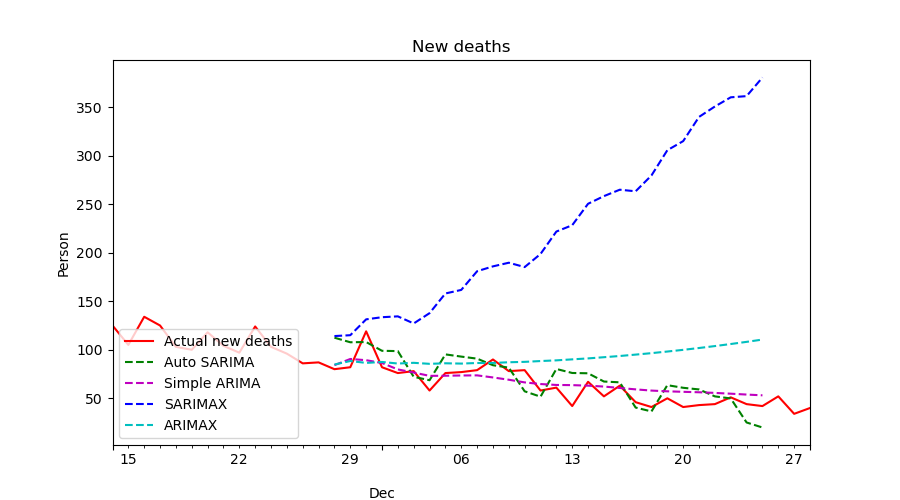

In [206]:
print('Prediction results for', prl, 'days followed by', train_len, 'days training samples:')
print('Auto SARIMA')
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, auto_arima_pr)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, auto_arima_pr)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, auto_arima_pr))))
print('Simple ARIMA')
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, arima_pr)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, arima_pr)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, arima_pr))))
srx_pr = srx_pr_df.values
print('SARIMAX')
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, srx_pr)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, srx_pr)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, srx_pr))))
arx_pr = arx_pr_df.values
print('ARIMAX')
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, arx_pr)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, arx_pr)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, arx_pr))))

fig, ax = plt.subplots(figsize=(9, 5))
ax.set(title='New deaths', xlabel='Date', ylabel='Person')
icf.iloc[train_len-14:train_len+prl + 3,4].plot(ax=ax, style='r', label='Actual new deaths')
auto_arima_pr_df.plot(ax=ax, style='g--', label='Auto SARIMA')
arima_pr_df.plot(ax=ax, style='m--', label='Simple ARIMA')
srx_pr_df.plot(ax=ax, style='b--', label='SARIMAX')
arx_pr_df.plot(ax=ax, style='c--', label='ARIMAX')
legend = ax.legend(loc='lower left')

## Conclusion

In this part of the study, we used four models and compared the concept, implementation and the performance of the models. The ARIMA model with (p, d, q) parameters, can deliver good estimation of the studied values. Seasonality of the data was observed using seasonal_decompose. The Auto ARIMA using the pmdarima library conducts a search on the parameters. It also takes seasonality input and find the best model. In the SARIMAX model, we have used total_vaccination and stringency_index as exogenous data. And finally in ARIMAX, seasonality was ignored, and the total_vaccination and stringency_index were used as  exogenous data.

The performance of the models was investigated in some sections known as test data. The results does not show improvement of the models using exogenous features in SARIMAX model over SARIMA or ARIMA. Both of the exogenous features have long term effects on the studied values. This implies that the use of total_vaccination and stringency_index as exogenous data requires further investigation on how to use them. 